In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))

print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(6432, 24)
(6432, 3)


# Multivariate Linear Regression (CoM Prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
X_motion_CoM.shape

(6432, 24)

In [8]:
idx_fr_rl_swinging = np.where(X_motion_CoM[:, -1] == 1)[0]
X_motion_CoM_FR_RL = X_motion_CoM[idx_fr_rl_swinging]
Y_motion_CoM_FR_RL = Y_motion_CoM[idx_fr_rl_swinging]
print(X_motion_CoM_FR_RL.shape)
print(Y_motion_CoM_FR_RL.shape)

(3218, 24)
(3218, 3)


## Predict CoM (x) movement

In [9]:
X_motion_CoM_FR_RL[0, :3]

array([0.0, 0.0, 0.0], dtype=object)

In [10]:
Y_motion_CoM_FR_RL[0, :]

array([0.018409550149297793, -0.0004566214849062167,
       -0.0029740427135168807], dtype=object)

### Linear Regression

In [37]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, 3:6], # Current motion command
               X_motion_CoM_FR_RL[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FR_RL[:, 6:8], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 15:17])) # RR (x, y) position
               
# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9762241608184535
RMSE:  0.00904452618222365
The lowest error is:  1.7065444460895307e-06
The highest error is:  0.04813323572920536
The avg. error is:  0.006582739491299804


In [38]:
model_fr_com_x.coef_

array([[ 1.03268731e-03, -2.77555756e-17,  2.35922393e-16,
         5.93903643e-02,  1.94289029e-16, -2.63677968e-16,
         2.90933785e-01, -1.49943607e-01,  3.91226961e-01,
        -4.96855886e-01, -1.10658750e-01,  1.23695592e-01,
         8.46186541e-03, -2.36744209e-01, -9.63138173e-01,
        -4.16354909e-02]])

In [39]:
model_fr_com_x.intercept_

array([-0.20782494])

In [29]:
#input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0, 0.237936324231, 0.188065700274, 0.234281409653, -0.171743092874, -0.249921495098, 0.161507381121, -0.259071586366, -0.138188475913]])
#output = input_ @ model_fr_com_x.coef_.T + model_fr_com_x.intercept_
#print(output)

Text(0, 0.5, 'Predictions')

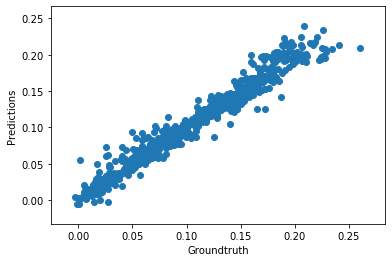

In [30]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [16]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

## Predict CoM -> y

### Linear Regression

In [40]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, 3:6], # Current motion command
               X_motion_CoM_FR_RL[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FR_RL[:, 6:8], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.29003734547019755
RMSE:  0.0034515794316650945
The lowest error is:  7.791516884403382e-06
The highest error is:  0.013907444100190236
The avg. error is:  0.00260755204228347


In [41]:
model_fr_com_y.coef_

array([[-6.44788745e-03, -1.38777878e-17, -6.93889390e-18,
         1.01141171e-02, -6.93889390e-17,  5.20417043e-18,
        -4.31941639e-02,  4.81233678e-02, -5.75765645e-03,
         7.20393932e-02, -9.61702969e-02, -1.24875340e-01,
         4.23705038e-02, -1.93827650e-01,  2.51685553e-01,
         3.81404173e-01]])

In [42]:
model_fr_com_y.intercept_

array([0.14942751])

Text(0, 0.5, 'Predictions')

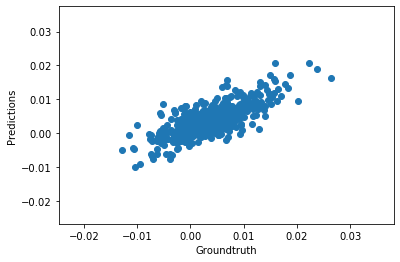

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [21]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

## Predict CoM -> Yaw

In [43]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, 3:6], # Current motion command
               X_motion_CoM_FR_RL[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FR_RL[:, 6:8], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -0.8741060915174059
RMSE:  0.002219602887588679
The lowest error is:  1.2688978993057043e-07
The highest error is:  0.016072963405146523
The avg. error is:  0.0016595266044344545


In [44]:
model_fl_com_theta.coef_

array([[-1.94816311e-03, -1.99493200e-17,  4.98732999e-18,
         1.85698894e-04,  1.64798730e-17,  3.46944695e-18,
         8.62290066e-03,  5.38926985e-03, -7.36832026e-02,
        -5.14519188e-02, -1.66177442e-02, -3.71722949e-02,
        -3.19216982e-02,  4.18597055e-02,  2.31608617e-02,
         1.66773126e-03]])

In [45]:
model_fl_com_theta.intercept_

array([0.01424054])

Text(0, 0.5, 'Predictions')

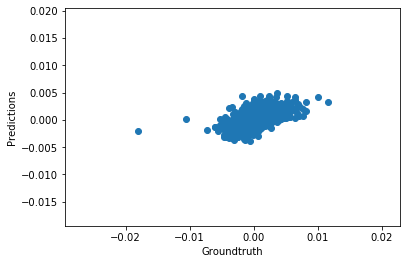

In [25]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")